# N-Player Shaping plots

In [2]:
# !pip install seaborn
import wandb
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
sns.set_theme(style="white", palette='colorblind')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
def vmap_smooth(scalars: np.array, weight: float):  # Weight between 0 and 1
    last = scalars[..., 0]  # First value in the plot (first timestep)
    smoothed = list()
    for i in range(scalars.shape[-1]):
        smoothed_val = last * weight + (1 - weight) * scalars[..., i]  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return np.stack(smoothed, axis=-1)

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [4]:
api = wandb.Api()

In [5]:
# globals: path, ylims, game_name
# path = '/Users/timonwilli/Documents/nshaper_figs/'
path = 'nshaper_figs/'
ylims = {'sd_3':(0,3), 'sd_4':(0,4), 'sd_5':(0,5), 'sh_3':(-3,4), 'sh_4':(-3,4.5), 'sh_5':(-3,4.8), 'tc_3':(-3,5), 'tc_4':(-3,5), 'tc_5':(-3,5), 'ipd_3':(0,5), 'ipd_4':(0,7), 'ipd_5':(0,9)}
game_name = {'sd': 'Snowdrift', 'ipd': 'Prisoner\'s Dilemma', 'sh': 'Stag Hunt', 'tc': 'Tragedy of the Commons'}


def plot_naive_rewards(game,num_pl,smooth_factor=0.99):
    runs = api.runs(path="ucl-dark/tensor",
     filters={"config.wandb.group": f"naive_{num_pl}pl_{game}"})
    plt.figure()
    rewards_dict = {pl_idx: [] for pl_idx in range(num_pl)}
    xs = []

    for run in runs:
        rew_keys = [f'train/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_pl)]
        df = run.scan_history(keys=rew_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        for pl_idx in range(num_pl):
            rewards_dict[pl_idx].append([row[f'train/reward_per_timestep/player_{pl_idx+1}'] for row in df])
    _xs = np.array(xs)
    smooth_rewards_dict = {pl_idx: vmap_smooth(np.array(rewards_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl)}


    x = _xs[0, :]
    medians = {pl_idx: np.median(smooth_rewards_dict[pl_idx], axis=0) for pl_idx in range(num_pl)}
    stds = {pl_idx: np.std(smooth_rewards_dict[pl_idx], axis=0) for pl_idx in range(num_pl)}

    for pl_idx in range(num_pl):
        plt.plot(x, medians[pl_idx], label=f"NL {pl_idx+1}")
        plt.fill_between(x, medians[pl_idx]-stds[pl_idx], medians[pl_idx]+stds[pl_idx], alpha=0.2)

    plt.legend(fontsize=15)
    # plt.xlim(0, 1250) # hmm
    plt.ylim(ylims[f'{game}_{num_pl}'][0]-0.2, ylims[f'{game}_{num_pl}'][1]+0.2)

    plt.xlabel("Episode", fontsize=15)
    plt.ylabel("Reward Per Timestep", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{game_name[game]} with {num_pl} Naive PPO Memory agents", fontsize=20)

    os.makedirs(path+f"{game}/{num_pl}_pl/eval/", exist_ok=True)
    plt.savefig(path+f"{game}/{num_pl}_pl/eval/naive_rewards.png", bbox_inches='tight')
    return plt

In [46]:
def plot_shaper_rewards(game,num_pl,num_shap,training_or_eval,smooth_factor=0,flip_dict =None,crop_to_shortest=False, only_seeds=None):
    if training_or_eval == 'training':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}"}, {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}"}]}
    elif training_or_eval == 'eval':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}-eval"},{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}_eval"},  {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}-eval"}]}
    else:
        raise ValueError("training_or_eval must be 'training' or 'eval'")
    runs = api.runs(path=f"ucl-dark/tensor-{game}",
     filters=group_filter)
    plt.figure()
    target_dict = {pl_idx: [] for pl_idx in range(num_pl-num_shap)}
    shaper_dict = {pl_idx: [] for pl_idx in range(num_shap)}
    xs = []

    tag = "train" if training_or_eval == 'training' else "eval"
    for run in runs:
        current_seed = run.config["seed"] if tag=="train" else int(run.name.split("-eval")[0][-1]) #evals end w/ seed-eval
        int(current_seed) # make sure it's an int
        if only_seeds is not None and current_seed not in only_seeds:
            continue
        if f'{tag}/reward_per_timestep/target_1' in run.history():
            target_keys = [f'{tag}/reward_per_timestep/target_{pl_idx+1}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/shaper_{pl_idx+1}' for pl_idx in range(num_shap)]
        else:
            target_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1+num_shap}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_shap)]
        df = run.scan_history(keys=target_keys+shaper_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        if not flip_dict or current_seed not in flip_dict.keys():
            for pl_idx,target_key in zip(range(num_pl-num_shap),target_keys):
                target_dict[pl_idx].append([row[target_key] for row in df])
            for pl_idx,shaper_key in zip(range(num_shap), shaper_keys):
                shaper_dict[pl_idx].append([row[shaper_key] for row in df])
        else:
            flips = flip_dict[current_seed]
            for pl_idx,target_key in zip(range(num_pl-num_shap),target_keys):
                target_dict[flips[pl_idx+num_pl-num_shap]].append([row[target_key] for row in df])
            for pl_idx,shaper_key in zip(range(num_shap), shaper_keys):
                shaper_dict[flips[pl_idx]].append([row[shaper_key] for row in df])
    if crop_to_shortest:
        min_len = min([len(x) for x in xs])
        xs = [x[:min_len] for x in xs]
        for pl_idx in range(num_pl-num_shap):
            target_dict[pl_idx] = [x[:min_len] for x in target_dict[pl_idx]]
        for pl_idx in range(num_shap):
            shaper_dict[pl_idx] = [x[:min_len] for x in shaper_dict[pl_idx]]
    _xs = np.array(xs)
    smooth_target_dict = {pl_idx: vmap_smooth(np.array(target_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl-num_shap)}
    smooth_shaper_dict = {pl_idx:  vmap_smooth(np.array(shaper_dict[pl_idx]),smooth_factor) for pl_idx in range(num_shap)}


    x = _xs[0, :]
    median_targets = {pl_idx: np.median(smooth_target_dict[pl_idx], axis=0) for pl_idx in range(num_pl-num_shap)}
    median_shapers = {pl_idx: np.median(smooth_shaper_dict[pl_idx], axis=0) for pl_idx in range(num_shap)}

    std_targets = {pl_idx: np.std(smooth_target_dict[pl_idx], axis=0) for pl_idx in range(num_pl-num_shap)}
    std_shapers = {pl_idx: np.std(smooth_shaper_dict[pl_idx], axis=0) for pl_idx in range(num_shap)}

    line_style_dict = {0: '-', 1: '--', 2: '-.', 3: ':'}
    for pl_idx in range(num_pl-num_shap):
        plt.plot(x, median_targets[pl_idx], label=f"NL {pl_idx+1}", linestyle=line_style_dict[pl_idx])
        plt.fill_between(x, median_targets[pl_idx]-std_targets[pl_idx], median_targets[pl_idx]+std_targets[pl_idx], alpha=0.3)
    for pl_idx in range(num_shap):
        plt.plot(x, median_shapers[pl_idx], label=f"Shaper {pl_idx+1}", linestyle=line_style_dict[pl_idx])
        plt.fill_between(x, median_shapers[pl_idx]-std_shapers[pl_idx], median_shapers[pl_idx]+std_shapers[pl_idx], alpha=0.3)


    plt.legend(fontsize=15)
    # plt.xlim(0, 1250) # hmm
    plt.ylim(ylims[f'{game}_{num_pl}'][0]-0.2, ylims[f'{game}_{num_pl}'][1]+0.2)

    plt.xlabel("Episode", fontsize=15)
    plt.ylabel("Reward Per Timestep", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{game_name[game]} with {num_shap} Shaper vs {num_pl-num_shap} Naive PPO Memory agents, {training_or_eval}", fontsize=20)

    os.makedirs(path+f"{game}/{num_pl}_pl/{training_or_eval}/", exist_ok=True)
    if only_seeds is None:
        plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_rewards.png", bbox_inches='tight')
    else:
        seeds ="_".join([str(seed) for seed in only_seeds])
        plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_rewards_seed{seeds}.png", bbox_inches='tight')

    return plt

## SD 3pl

### Naive

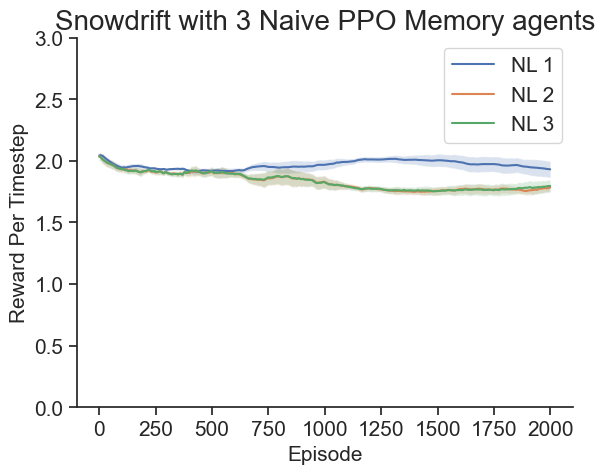

In [6]:
plot_naive_rewards("sd",3).show()

### 1 shaper

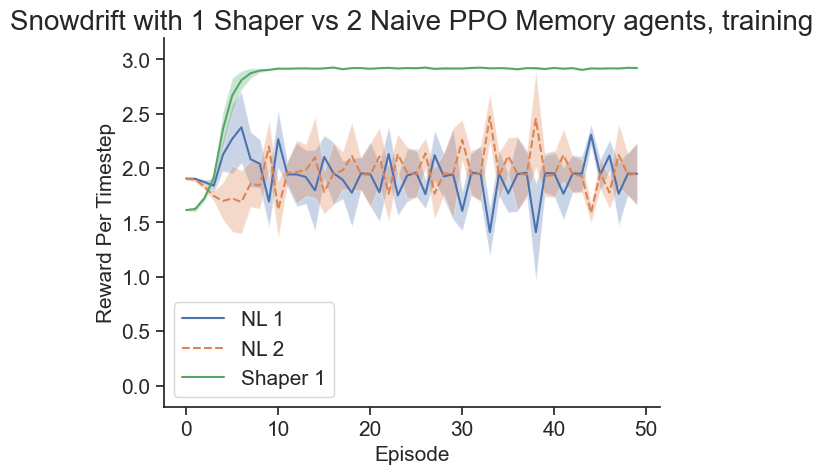

In [78]:
plot_shaper_rewards("sd",3,1,'training', smooth_factor=0).show()


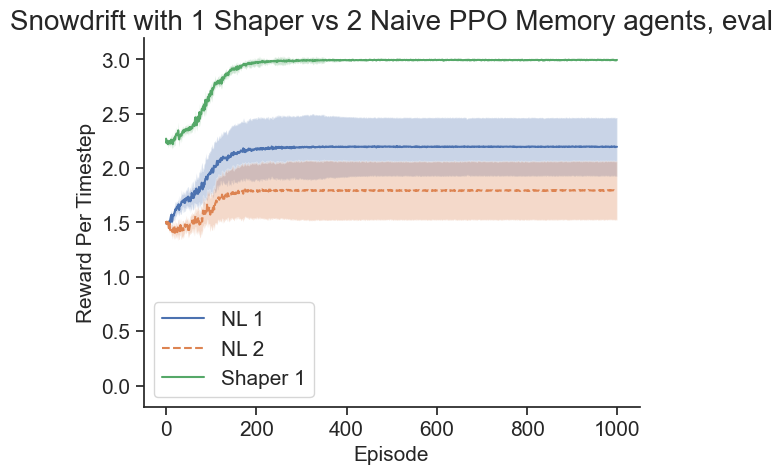

In [79]:
plot_shaper_rewards("sd",3,1,'eval', smooth_factor=0).show()

### 2 shaper

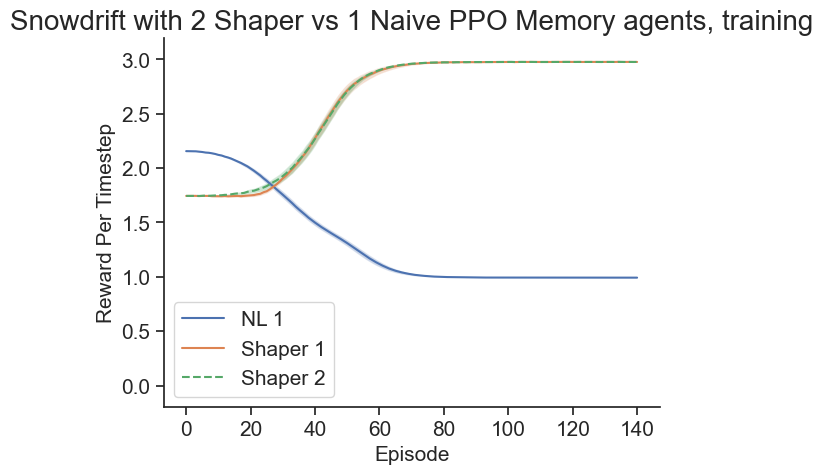

In [80]:
plot_shaper_rewards("sd",3,2,'training', crop_to_shortest=True, smooth_factor=0).show()

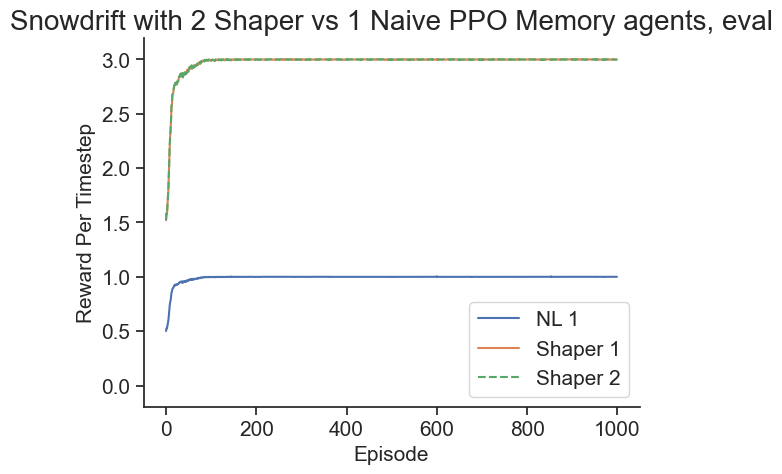

In [81]:
plot_shaper_rewards("sd",3,2,'eval', smooth_factor=0).show()

## SD 4pl

### Naive

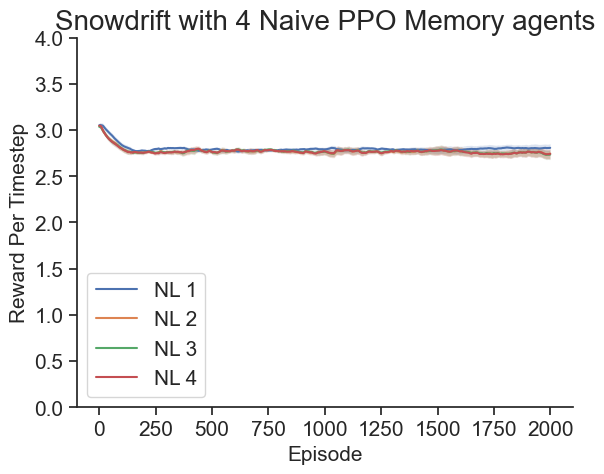

In [10]:
plot_naive_rewards("sd",4).show()

### 1 shaper - seeds diverged
seed 1 and 5 achieves perfect score for 3 out of 4 players!  
seed 2,3,4 gets all the NLs equally exploited

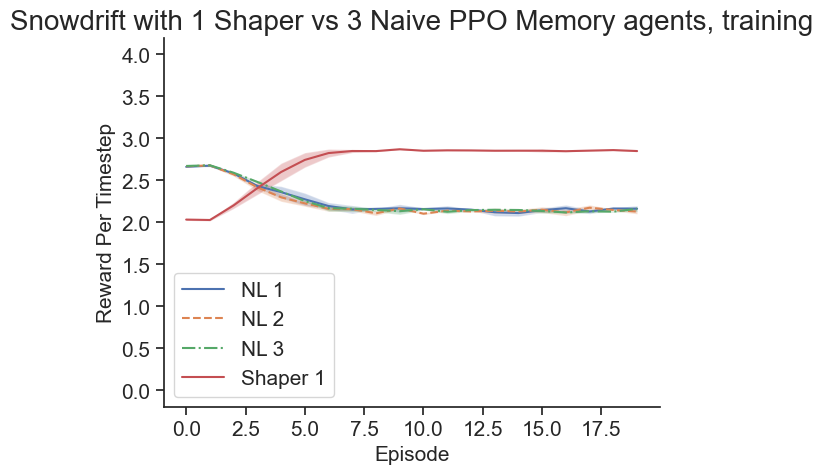

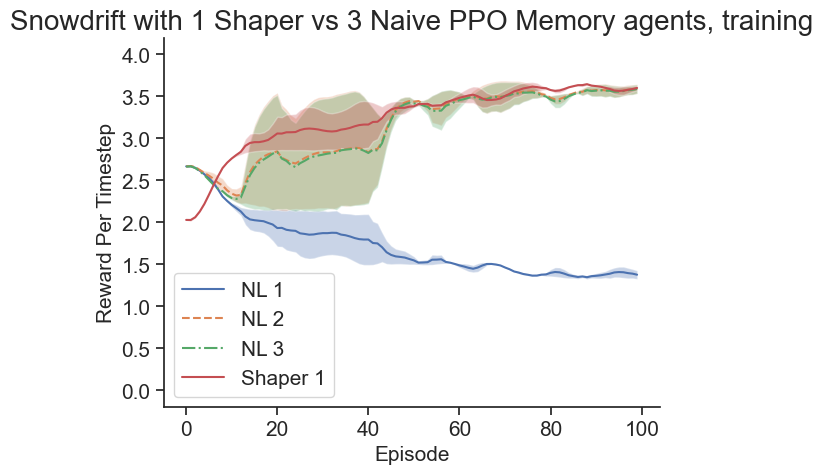

In [87]:
plot_shaper_rewards("sd",4,1,'training', only_seeds=[2,3,4], smooth_factor=0).show()
plot_shaper_rewards("sd",4,1,'training', only_seeds=[1,5], smooth_factor=0.7).show()

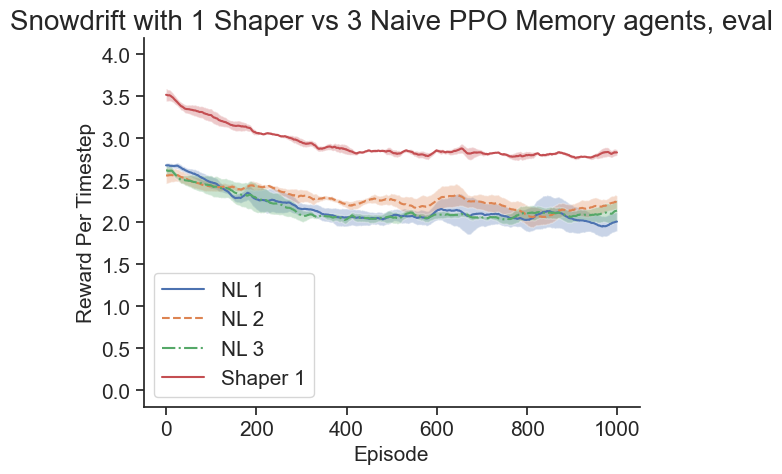

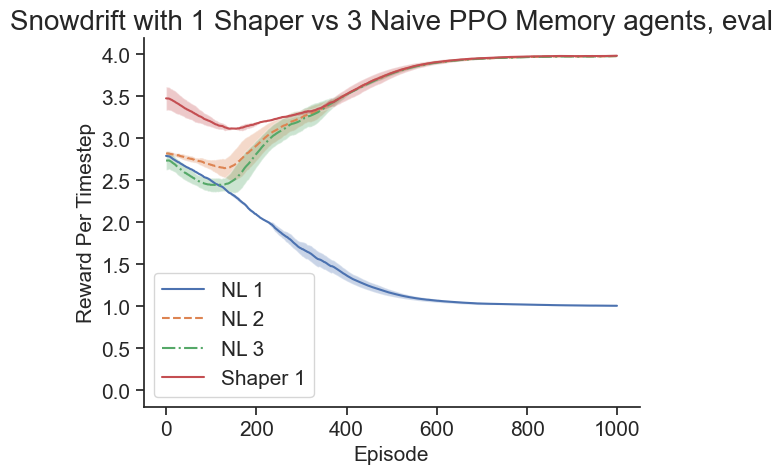

In [89]:
plot_shaper_rewards("sd",4,1,'eval', only_seeds=[2,3,4], smooth_factor=0.99).show()
plot_shaper_rewards("sd",4,1,'eval', only_seeds=[1,5], smooth_factor=0.99).show()

### 2 shapers

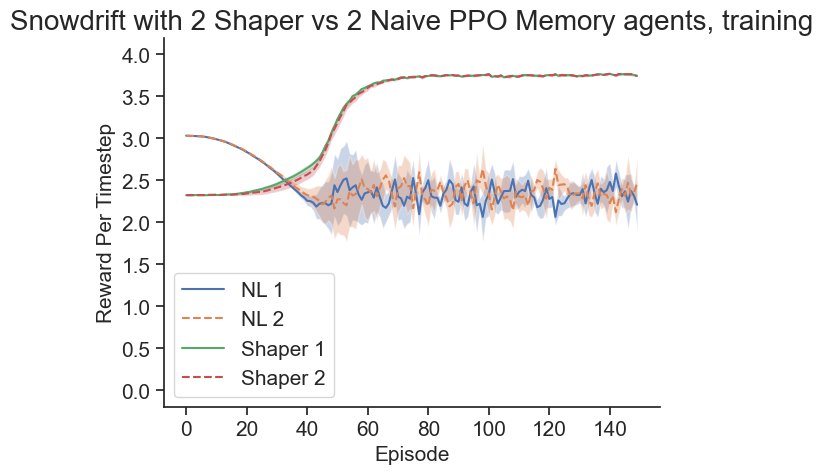

In [9]:
plot_shaper_rewards("sd",4,2,'training', smooth_factor=0.5).show()

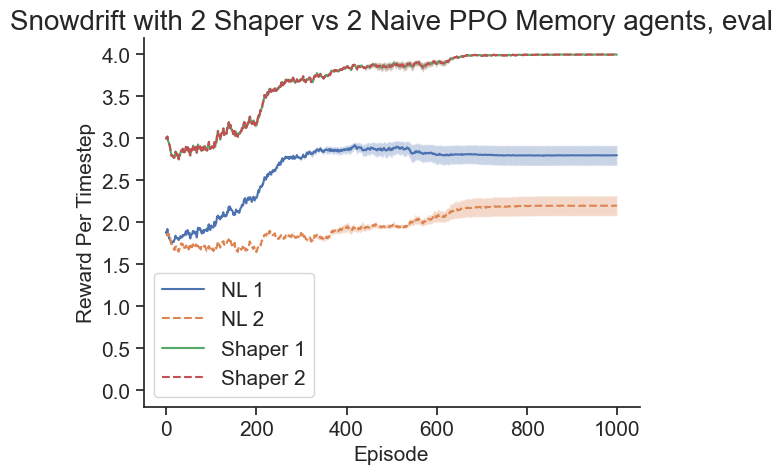

In [13]:
plot_shaper_rewards("sd",4,2,'eval', smooth_factor=0.5).show()

### 3 shapers

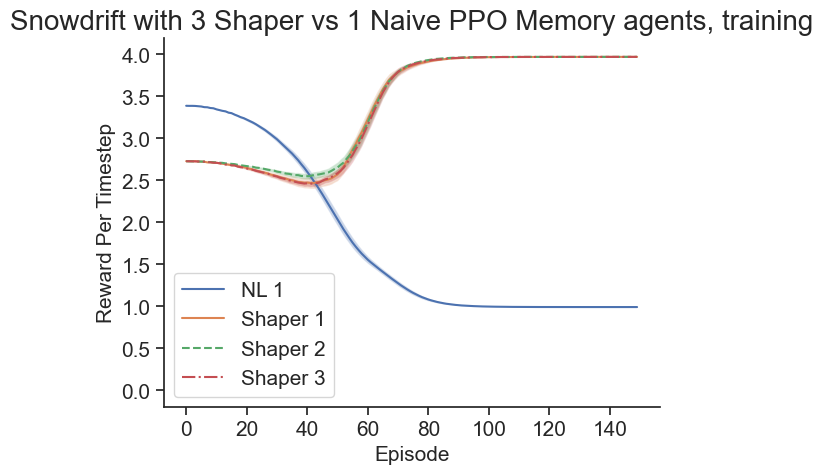

In [14]:
plot_shaper_rewards("sd",4,3,'training').show()

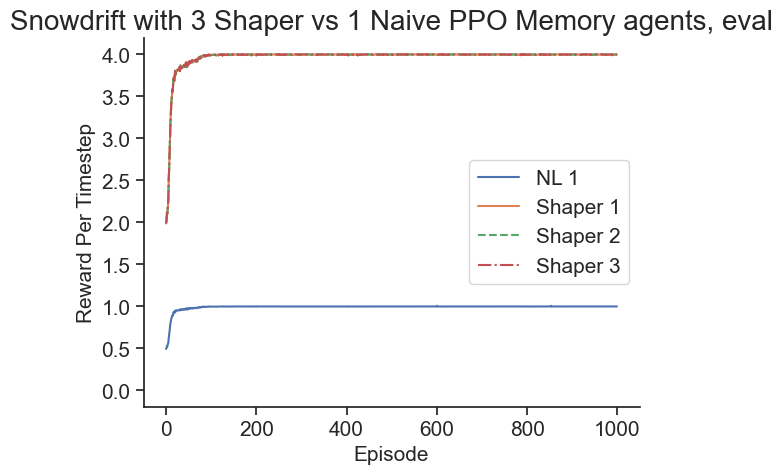

In [15]:
plot_shaper_rewards("sd",4,3,'eval').show()

## SH 3pl


### Naive


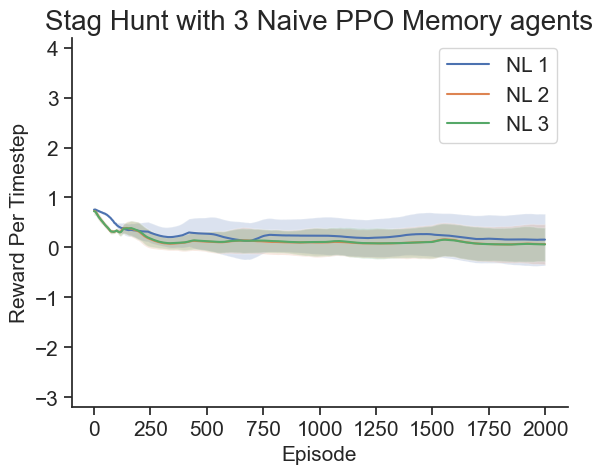

In [18]:
plot_naive_rewards("sh",3).show()

### 1 shaper
seeds 1,2,4 is really good, shaper gets max score - can we ditch the rest?  
seed 5 is a bit worse and tbh didn't converge   
seed 3 is really bad, they just weirdly defected idk whats up with that


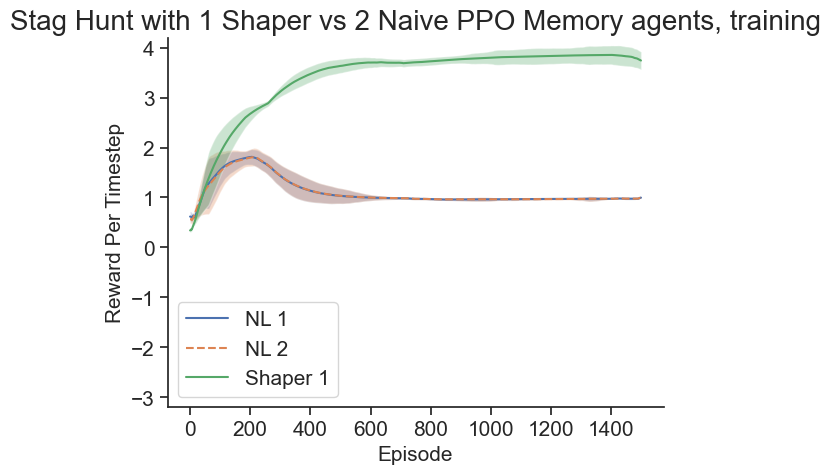

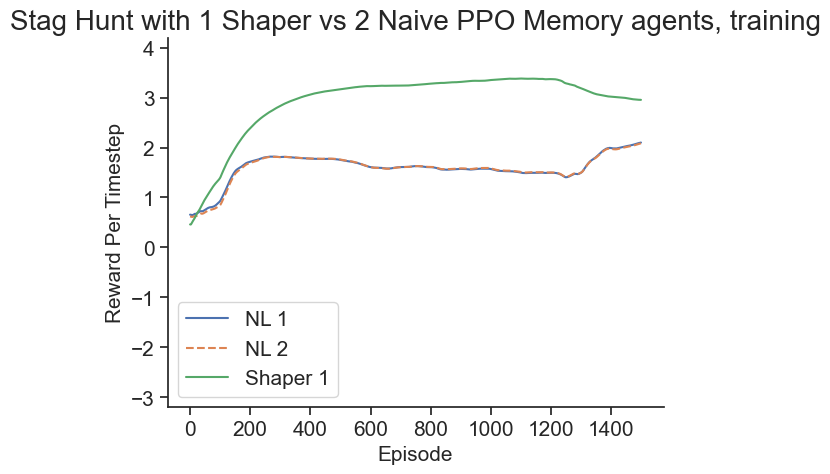

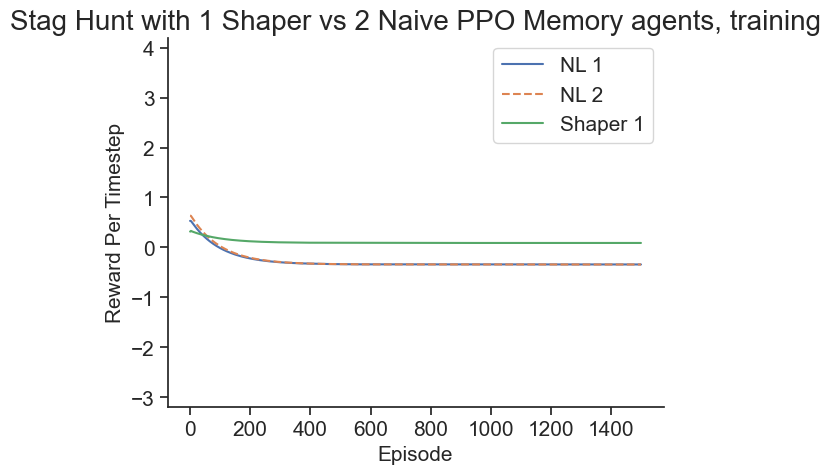

In [45]:
plot_shaper_rewards("sh",3,1,'training', smooth_factor=0.99, only_seeds=[1,2,4]).show()
plot_shaper_rewards("sh",3,1,'training', smooth_factor=0.99, only_seeds=[5]).show()
plot_shaper_rewards("sh",3,1,'training', smooth_factor=0.99, only_seeds=[3]).show()

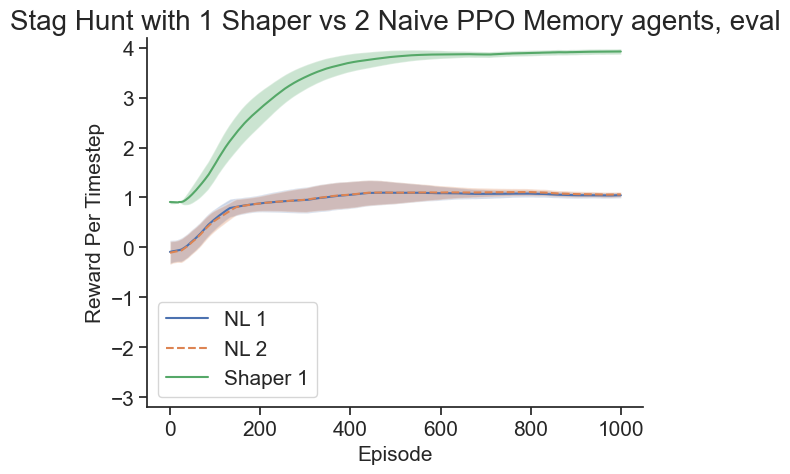

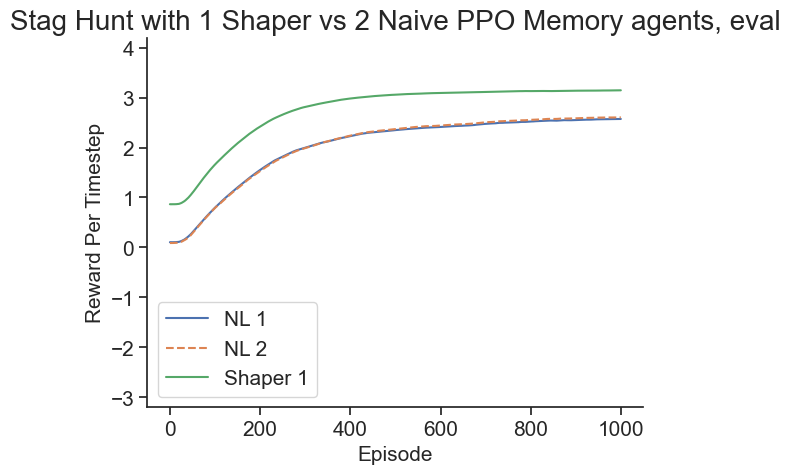

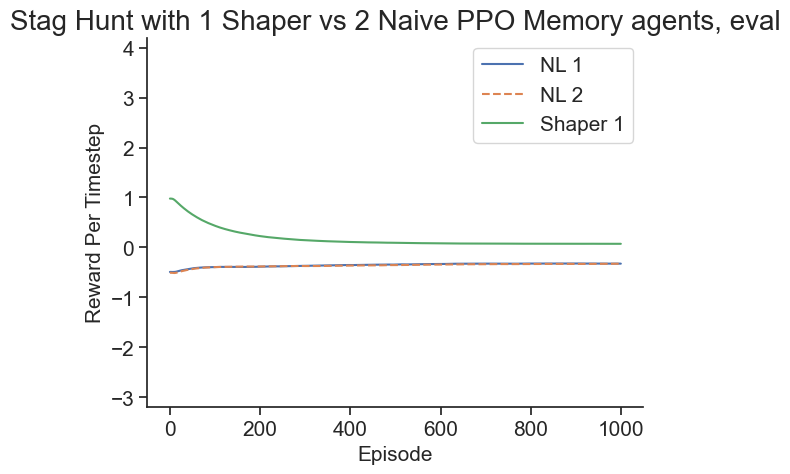

In [47]:

plot_shaper_rewards("sh",3,1,'eval', smooth_factor=0.99, only_seeds=[1,2,4]).show()
plot_shaper_rewards("sh",3,1,'eval', smooth_factor=0.99, only_seeds=[5]).show()
plot_shaper_rewards("sh",3,1,'eval', smooth_factor=0.99, only_seeds=[3]).show()


### 2 shaper


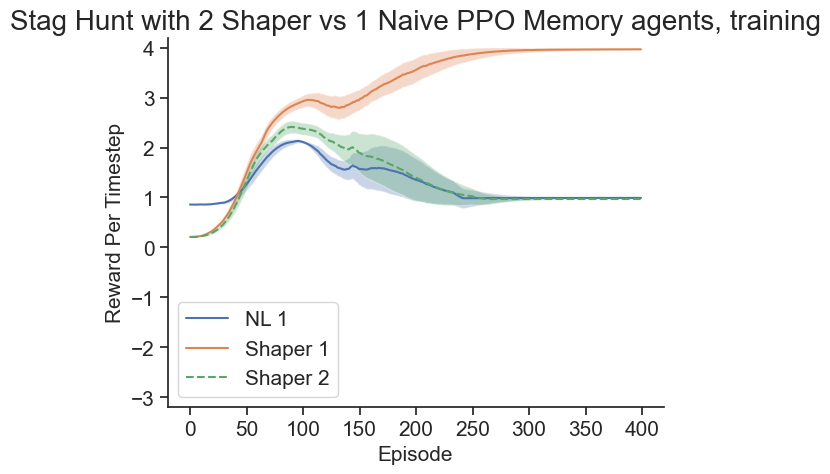

In [52]:
plot_shaper_rewards("sh",3,2,'training', smooth_factor=0.5, flip_dict={1:[1,0],3:[1,0]}).show()


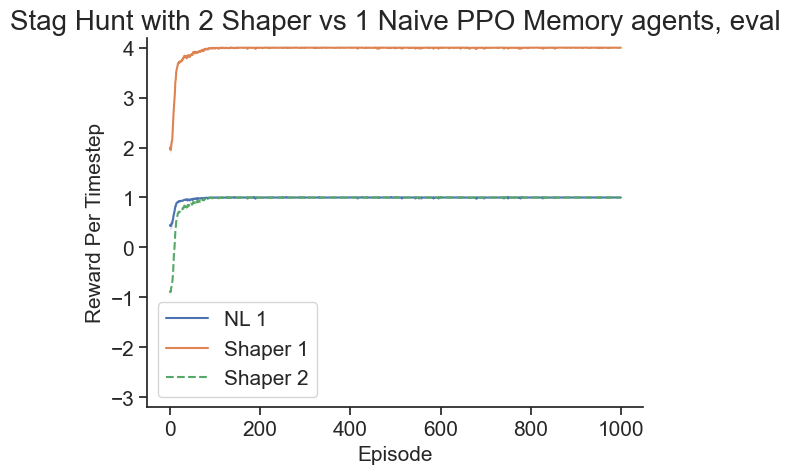

In [78]:
plot_shaper_rewards("sh",3,2,'eval', smooth_factor=0, flip_dict={1:[1,0],3:[1,0]}).show()

## SH 4pl


### Naive


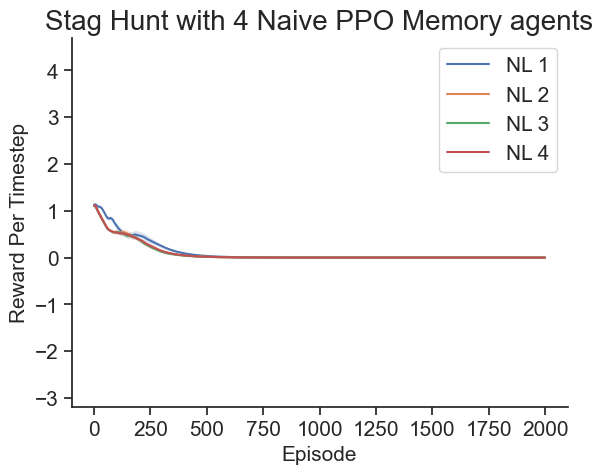

In [80]:
plot_naive_rewards("sh",4).show()


### 1 shaper


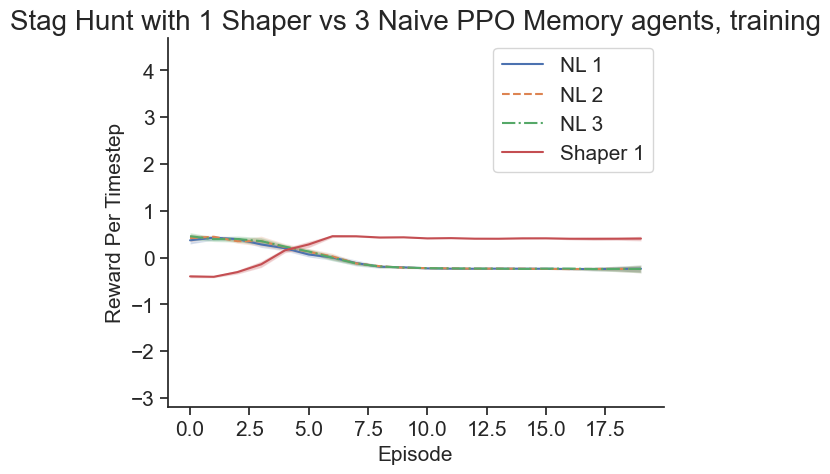

In [81]:
plot_shaper_rewards("sh",4,1,'training', smooth_factor=0).show()


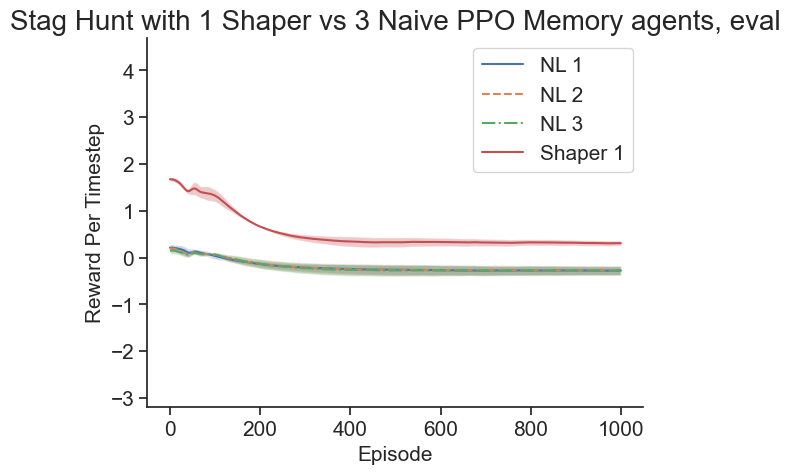

In [85]:
plot_shaper_rewards("sh",4,1,'eval',  smooth_factor=0.99).show()


### 2 shapers


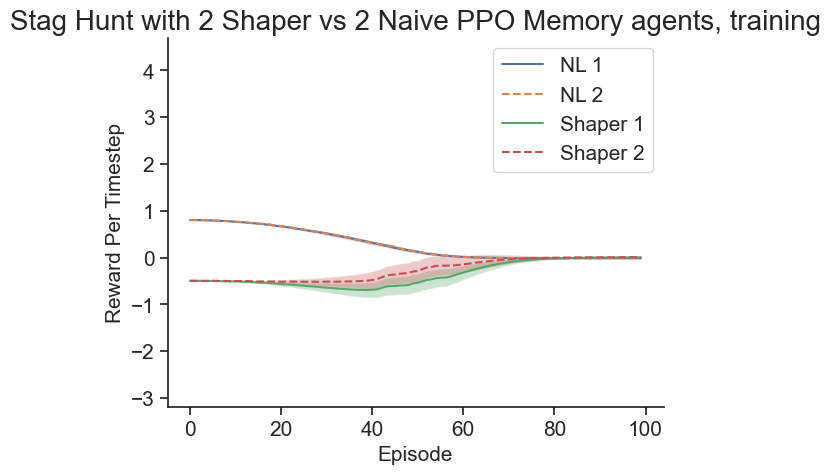

In [86]:
plot_shaper_rewards("sh",4,2,'training', smooth_factor=0).show()


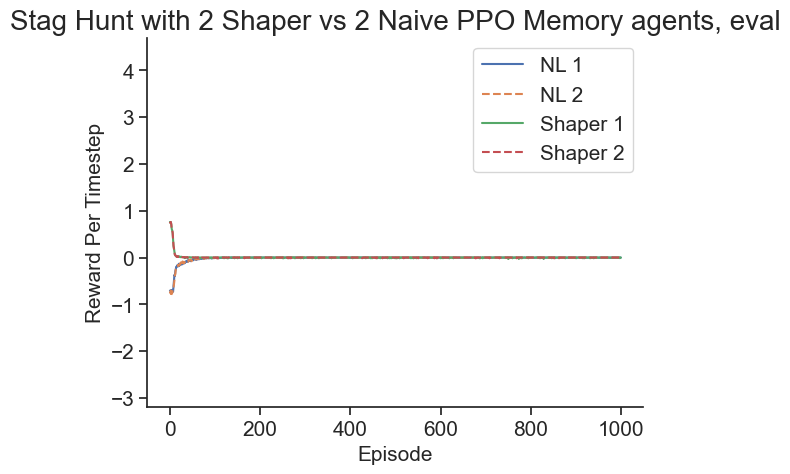

In [87]:
plot_shaper_rewards("sh",4,2,'eval', smooth_factor=0).show()


### 3 shapers


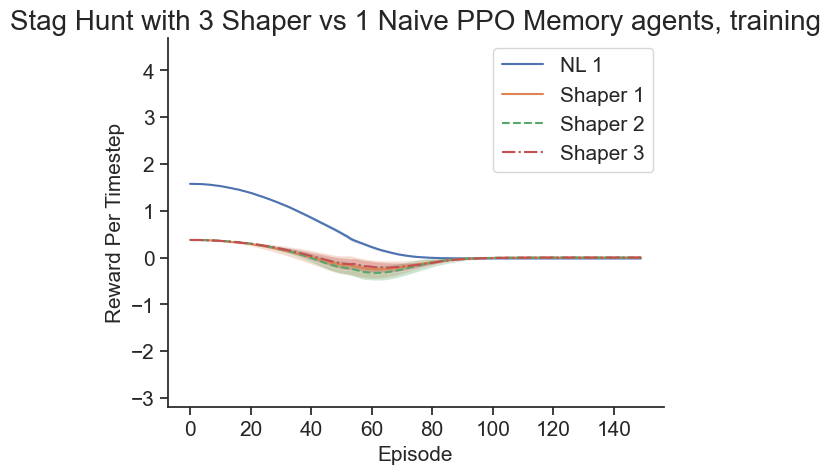

In [89]:
plot_shaper_rewards("sh",4,3,'training').show()


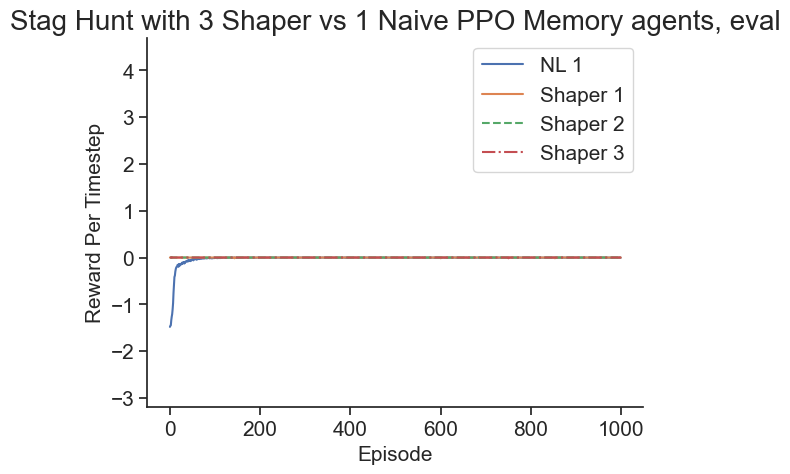

In [90]:
plot_shaper_rewards("sh",4,3,'eval').show()

## TC 3pl


### Naive


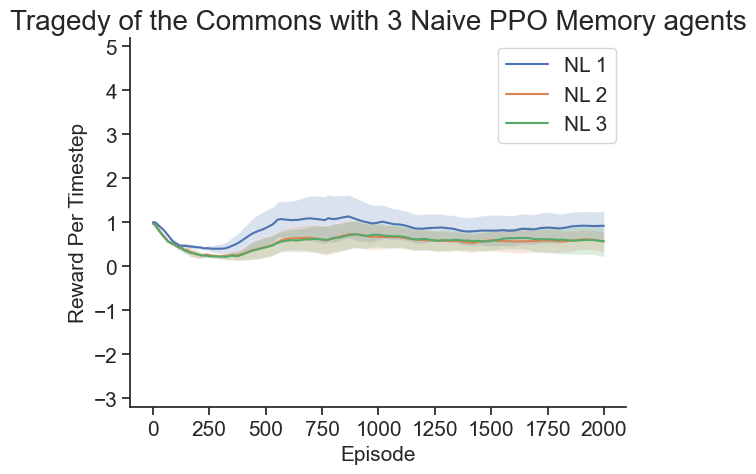

In [8]:
plot_naive_rewards("tc",3, smooth_factor=0.99).show()


### 1 shaper


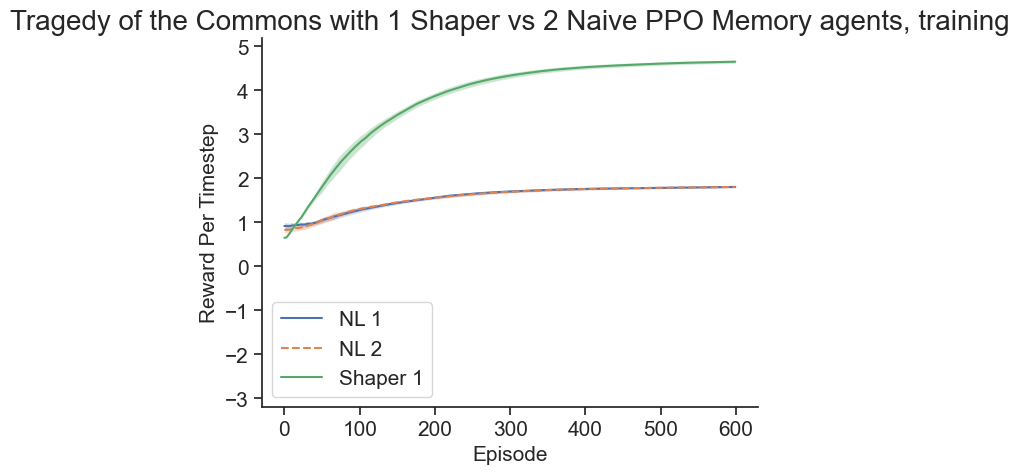

In [10]:
plot_shaper_rewards("tc",3,1,'training', smooth_factor=0.99).show()

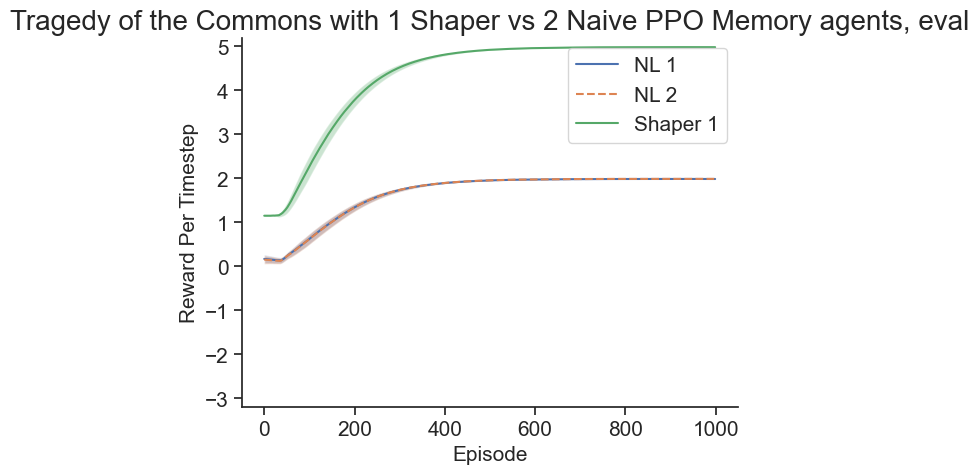

In [12]:

plot_shaper_rewards("tc",3,1,'eval', smooth_factor=0.99).show()


### 2 shaper


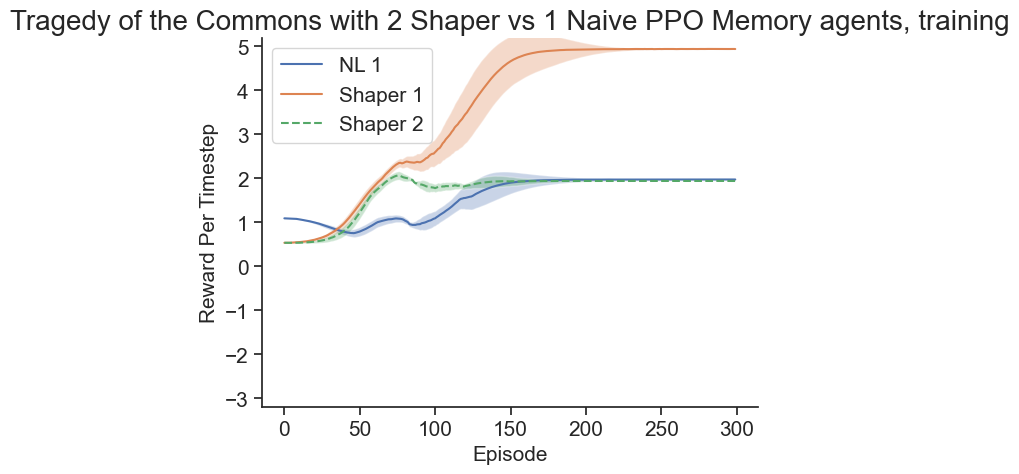

In [17]:
plot_shaper_rewards("tc",3,2,'training', flip_dict={1:[1,0],3:[1,0]}, smooth_factor=0.5).show()


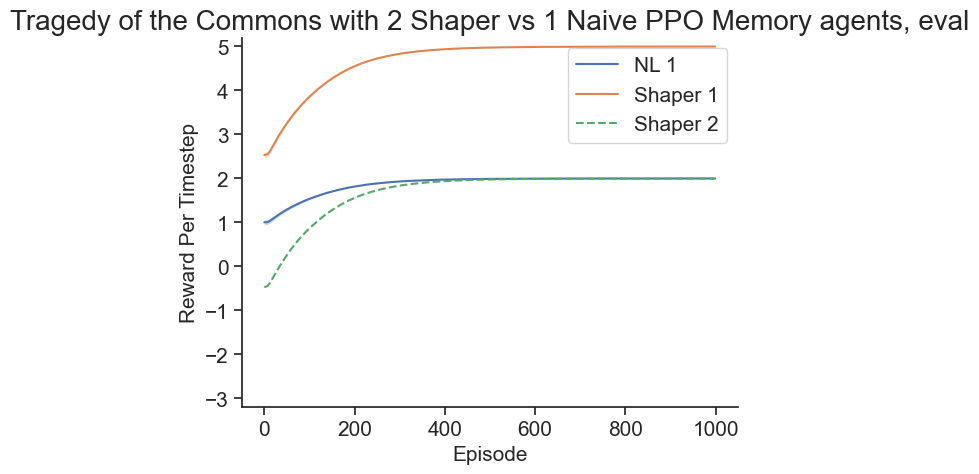

In [18]:
plot_shaper_rewards("tc",3,2,'eval',  flip_dict={1:[1,0],3:[1,0]},smooth_factor=0.99).show()

## TC 4pl


### Naive


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


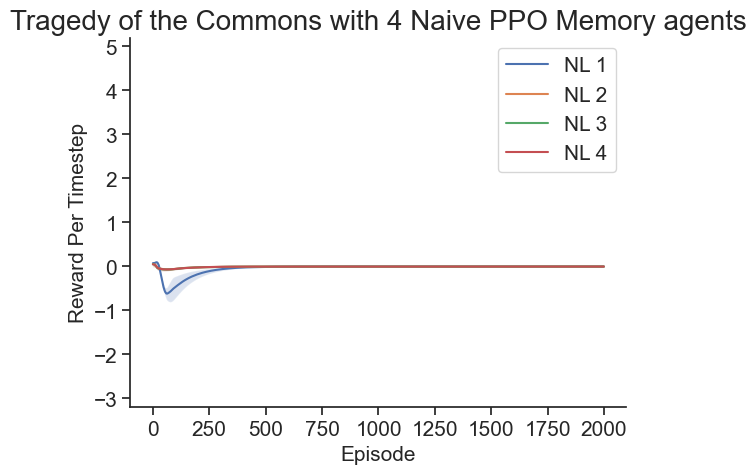

In [66]:
plot_naive_rewards("tc",4).show()


### 1 shaper
seed 3 is weird


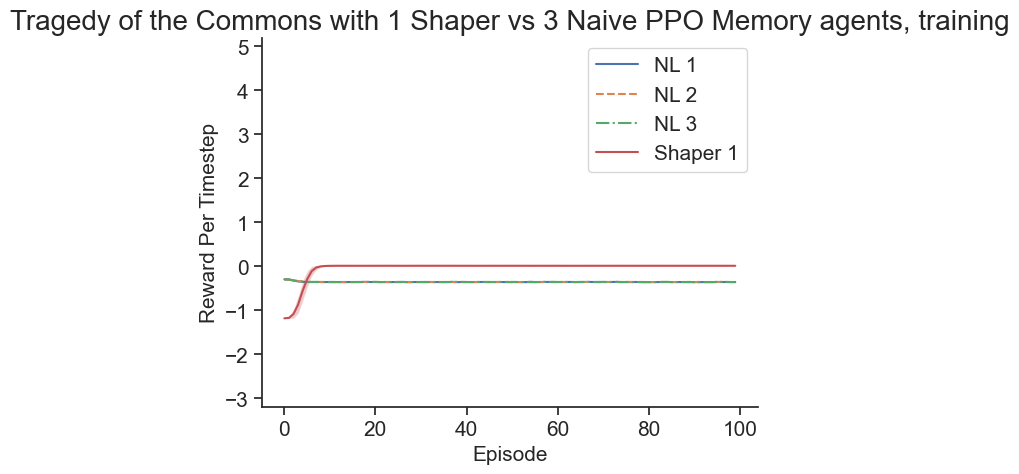

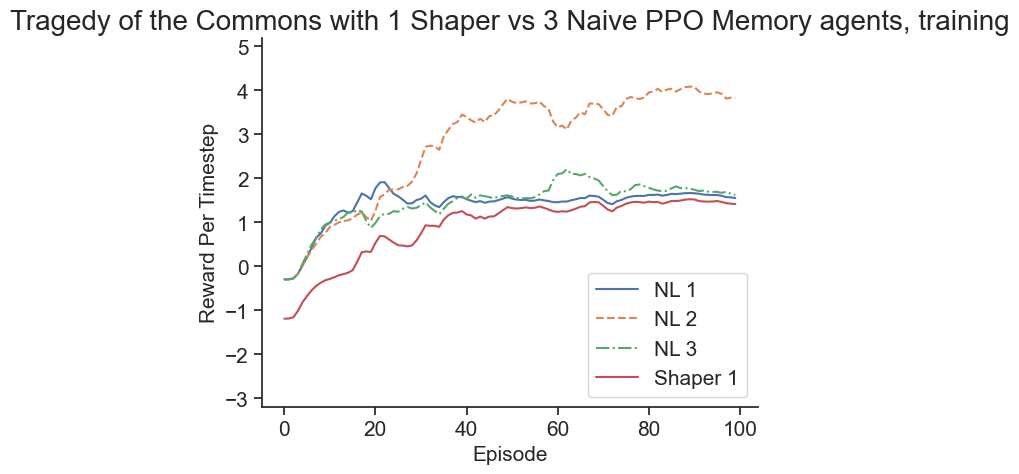

In [24]:
plot_shaper_rewards("tc",4,1,'training',only_seeds=[1,2,4,5], smooth_factor=0).show()
plot_shaper_rewards("tc",4,1,'training',only_seeds=[3], smooth_factor=0.7).show()

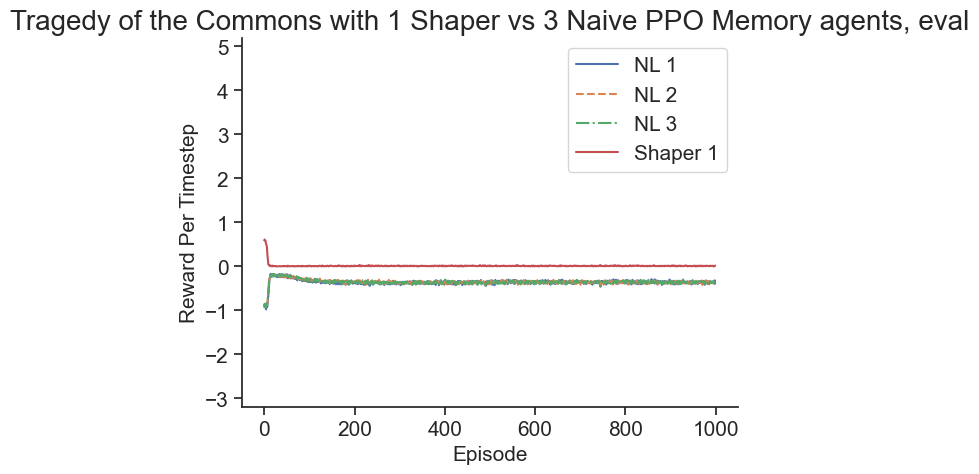

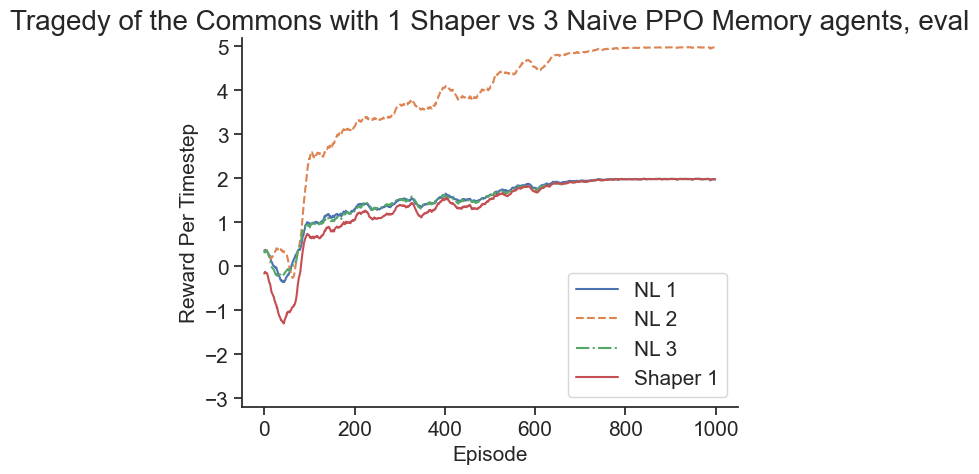

In [26]:
plot_shaper_rewards("tc",4,1,'eval',only_seeds=[1,2,4,5], smooth_factor=0).show()
plot_shaper_rewards("tc",4,1,'eval',only_seeds=[3], smooth_factor=0.7).show()

### 2 shapers


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


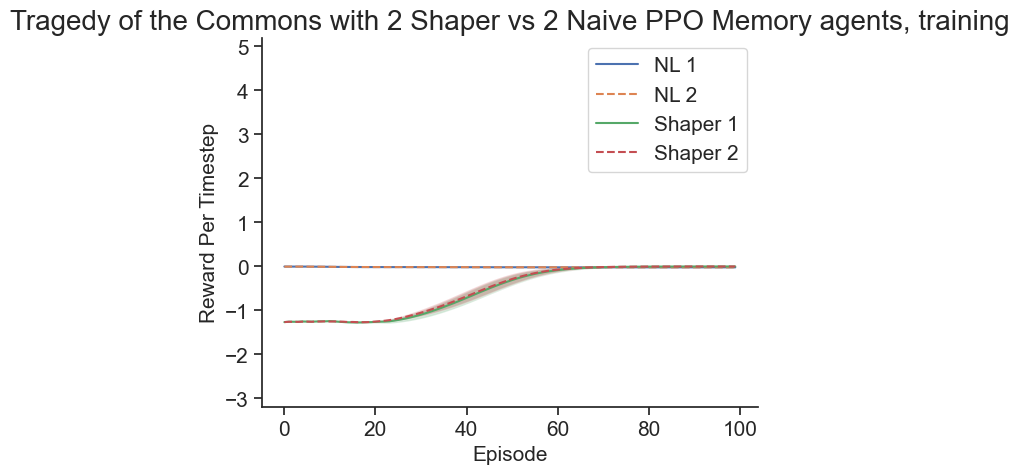

In [27]:
plot_shaper_rewards("tc",4,2,'training', smooth_factor=0.5).show()


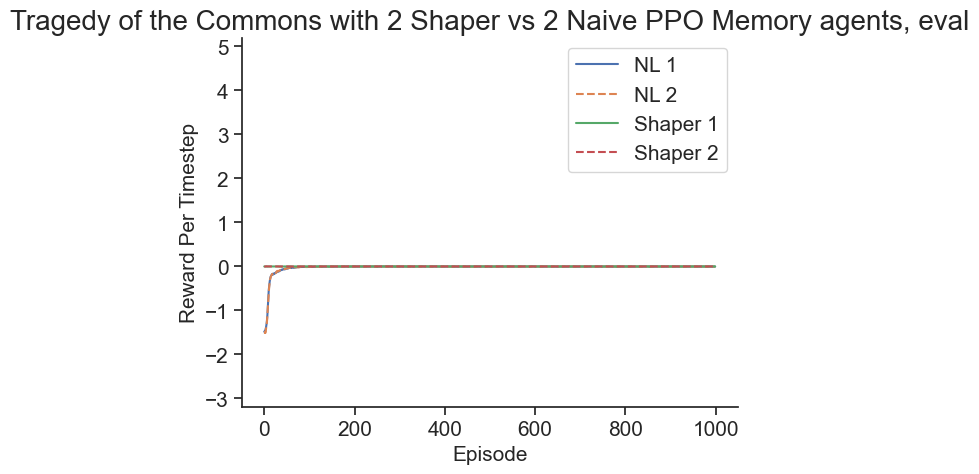

In [28]:
plot_shaper_rewards("tc",4,2,'eval', smooth_factor=0.5).show()


### 3 shapers


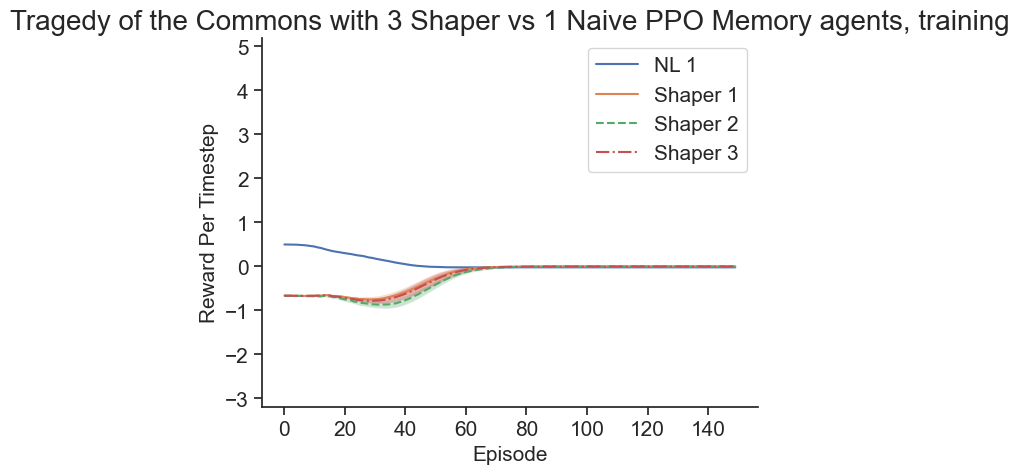

In [29]:
plot_shaper_rewards("tc",4,3,'training').show()


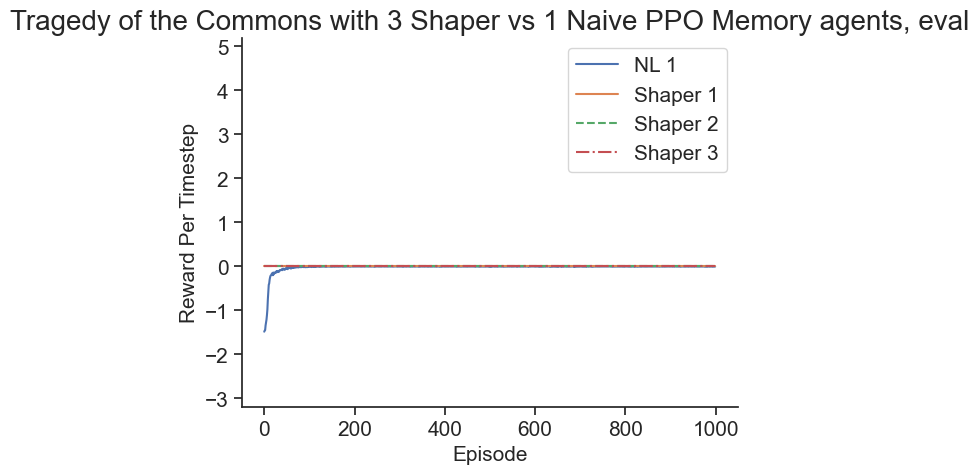

In [30]:
plot_shaper_rewards("tc",4,3,'eval').show()

## IPD 3pl



### Naive


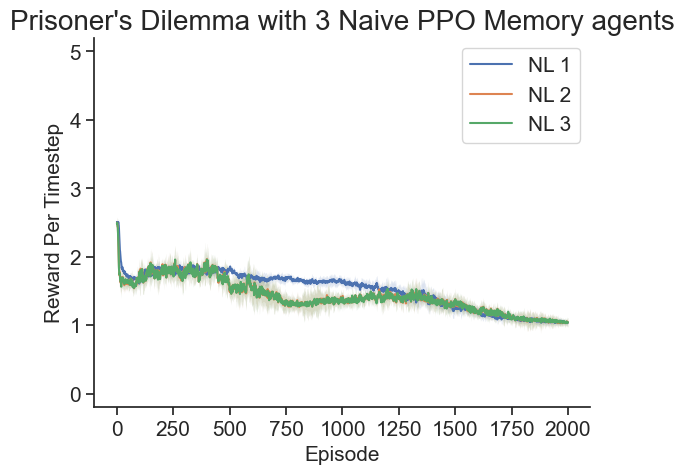

In [44]:

plot_naive_rewards("ipd",3, smooth_factor=0).show()



### 1 shaper

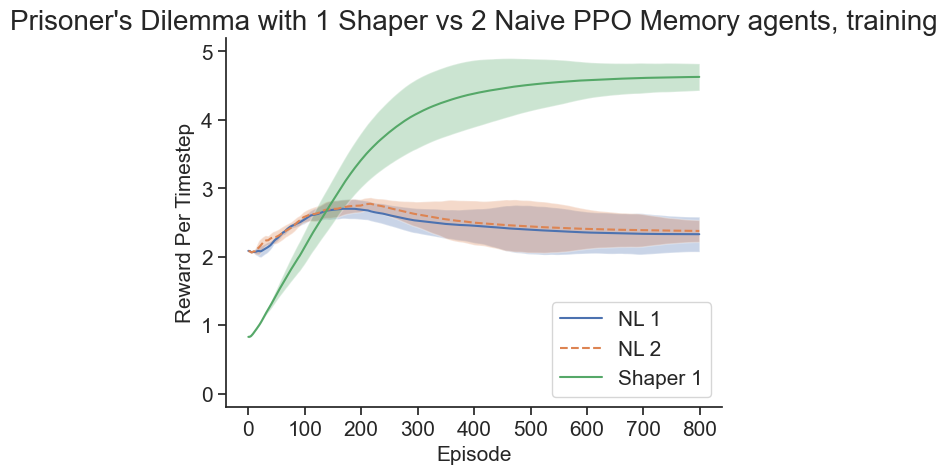

In [56]:

plot_shaper_rewards("ipd",3,1,'training',only_seeds=[0,1,2,3,4], smooth_factor=0.99).show()


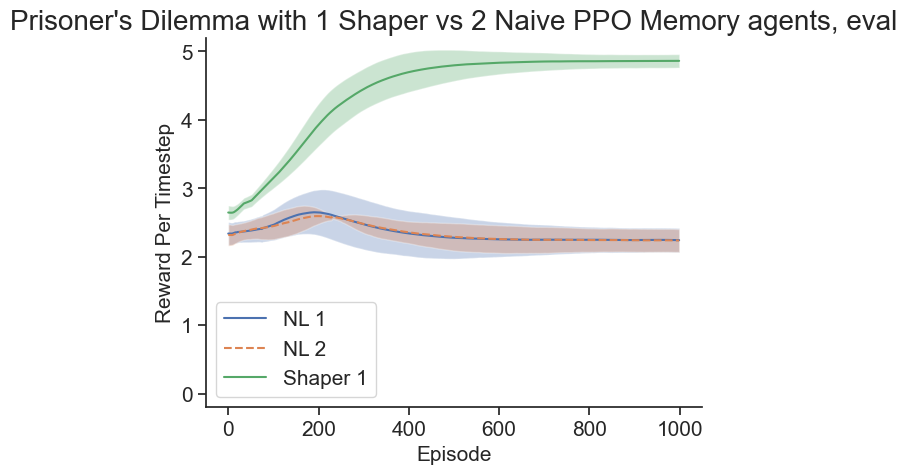

In [57]:

plot_shaper_rewards("ipd",3,1,'eval', smooth_factor=0.99).show()



### 2 shaper


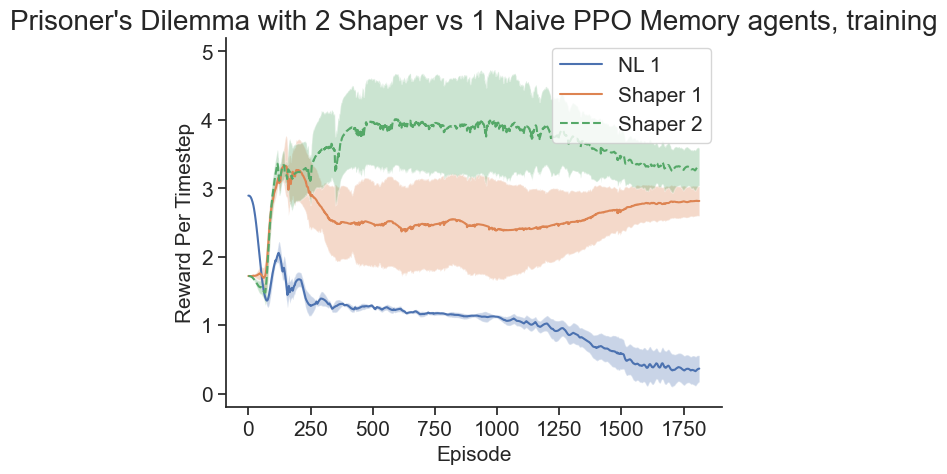

In [65]:

plot_shaper_rewards("ipd",3,2,'training', flip_dict={3:[1,0]}, smooth_factor=0.7, crop_to_shortest=True).show()


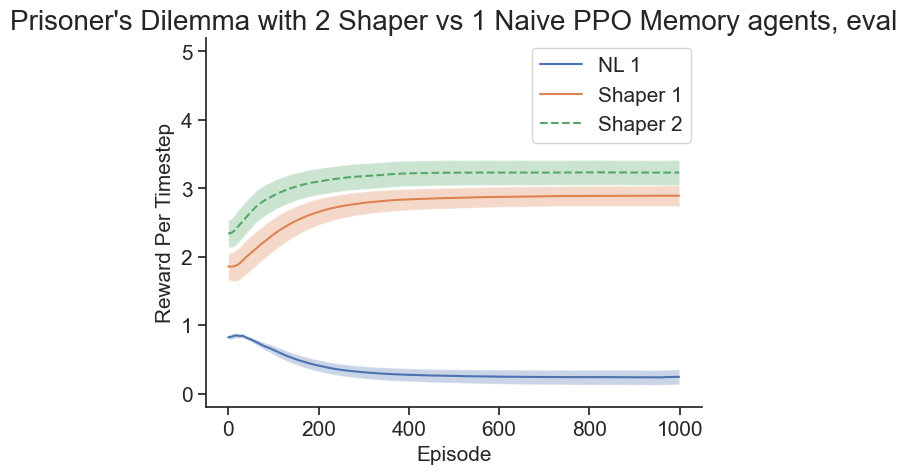

In [59]:

plot_shaper_rewards("ipd",3,2,'eval',  flip_dict={3:[1,0]},smooth_factor=0.99).show()

## IPD 4pl



### Naive


In [67]:

plot_naive_rewards("ipd",4).show()


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: Network error (ConnectTimeout), entering retry loop.



### 1 shaper


In [ ]:

plot_shaper_rewards("ipd",4,1,'training', smooth_factor=0).show()


In [ ]:
plot_shaper_rewards("ipd",4,1,'eval', smooth_factor=0).show()


### 2 shapers


In [ ]:

plot_shaper_rewards("ipd",4,2,'training', smooth_factor=0.5).show()


In [ ]:

plot_shaper_rewards("ipd",4,2,'eval', smooth_factor=0.5).show()



### 3 shapers


In [ ]:

plot_shaper_rewards("ipd",4,3,'training').show()


In [ ]:

plot_shaper_rewards("ipd",4,3,'eval').show()